<a href="https://colab.research.google.com/github/Yuncci/AI_final_project/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab 程式碼

# Step 0: 安裝相關套件

In [1]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 29.09 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [2]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 

# Step 1: Dataset



In [3]:
import gdown
url = 'https://drive.google.com/file/d/1RPqAuB_dtmf_29mjaRcf1NVOm8--suxm/view?usp=drive_link'
gdown.download(url, fuzzy = True)

!unzip -q cat_dog_test1.zip

Downloading...
From: https://drive.google.com/uc?id=1RPqAuB_dtmf_29mjaRcf1NVOm8--suxm
To: /content/cat_dog_test1.zip
100%|██████████| 22.9M/22.9M [00:00<00:00, 127MB/s]


In [4]:
import os
main_dir = "cat_dog_test1/"

images_files = []
for dir_path, dir_names, file_names in os.walk(main_dir):
  for file in file_names:
    images_files.append(os.path.join(dir_path, file))

print(f"Photos found: {len(images_files)}")

text_files = ['dog', 'plane', 'cat', 'car', 'drink', 'couple', 'moon', 'boat', 'suit', 'tree']

Photos found: 1008


# Step 2: 使用 CLIP 模型

In [5]:
import math
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from pathlib import Path

%matplotlib inline

In [6]:
from CLIP.clip import clip

# 載入CLIP模型，在這邊用的是ViT-B/32，若想嘗試其他預訓練模型架構可以用 clip.available_models() 看到所有可用模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 201MiB/s]


In [7]:
def get_text_embedding(model, text_query):
  with torch.no_grad():
    text_embedding = model.encode_text(clip.tokenize(text_query).to(device))
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)

  return text_embedding.cpu().numpy()


def get_image_embedding(model, images):

  image_preproc = torch.stack([preprocess(image) for image in images]).to(device)

  with torch.no_grad():
    image_embeddings = model.encode_image(image_preproc)
    image_embeddings = image_embeddings / image_embeddings.norm(dim = -1, keepdim = True)
  
  return image_embeddings.cpu().numpy()


batch_size = 32
image_embeddings = []

# 依據每個batch得到圖片的embedding，避免記憶體爆炸
for i in tqdm(range(math.ceil(len(images_files)/batch_size))):

  batch_files = images_files[batch_size * i : batch_size * (i+1)]
  
  batch_images = [Image.open(path) for path in batch_files]
  batch_embeddings = get_image_embedding(model, batch_images)
  image_embeddings.append(batch_embeddings)


image_embeddings = np.concatenate(image_embeddings)


# 得到文字敘述的embedding
text_embeddings = get_text_embedding(model, text_files)

100%|██████████| 32/32 [02:40<00:00,  5.00s/it]


# Step 3: 以文字/圖片搜尋圖片

In [8]:


def find_best_matches(text_embeddings, image_embeddings, images_files, results_count):
  similarities = (image_embeddings @ text_embeddings.T).squeeze(1)
  best_match_image_idx = (-similarities).argsort()

  return [images_files[i] for i in best_match_image_idx[:results_count]], similarities[best_match_image_idx]

def text_query_image(model, text_query, image_embeddings, images_files, result_count=3):
  text_embeddings = get_text_embedding(model, text_query)
  
  best_image_ids, best_similarities = find_best_matches(text_embeddings, image_embeddings, images_files, result_count)

  plt.figure(figsize = (20, 10))
  for i, path in enumerate(best_image_ids):
    plt.subplot(1, len(best_image_ids), i+1)
    plt.imshow(Image.open(path))
    plt.title(f"similarity : {best_similarities[i]}")
  plt.tight_layout()
  plt.show()



def image_query_image(model, image_query, image_embeddings, images_files, result_count=3):
    # 讀取並編碼查詢圖片
    query_image = [Image.open(image_query)]
    query_embedding = get_image_embedding(model, query_image)

    # 計算圖片之間的相似度
    similarities = (image_embeddings @ query_embedding.T).squeeze(1)
    best_match_indices = (-similarities).argsort()

    # 取出相似度最高的前n個圖片
    best_image_indices = best_match_indices[:result_count]
    best_image_files = [images_files[i] for i in best_image_indices]
    best_similarities = similarities[best_image_indices]

    # 顯示相似的圖片和相似度分數
    plt.figure(figsize=(20, 10))
    for i, file in enumerate(best_image_files):
        plt.subplot(1, len(best_image_files), i + 1)
        image = Image.open(file)
        plt.imshow(image)
        plt.title(f"Similarity: {best_similarities[i]}")

    
    plt.tight_layout()
    plt.show()




In [11]:
def image_query_text(model, image_query, image_embeddings, text_embeddings, text_files, result_count=1):
    # 讀取並編碼查詢圖像
    query_image = [Image.open(image_query)]
    query_embedding = get_image_embedding(model, query_image)

    # 轉置查詢圖像的嵌入向量
    query_embedding = query_embedding.T

    # 計算圖像和文本之間的相似度
    similarities = (text_embeddings @ query_embedding).squeeze(1)
    best_match_indices = (-similarities).argsort()

    # 取出相似度最高的前n个文本
    best_text_indices = best_match_indices[:result_count]
    # print(best_match_indices)
    best_text_files = [text_files[i] for i in best_text_indices]
    best_similarities = similarities[best_text_indices]

    return best_text_files



# 圖像辨識

In [ ]:
import os
from PIL import Image

folder_path = 'dog/'  # 資料夾路徑

# 獲取資料夾中所有的檔案名稱
file_names = os.listdir(folder_path)


correct = 0
# 遍歷檔案名稱列表，讀取圖片檔案
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    
    # 在這裡對圖片進行處理，例如顯示、儲存或進一步分析
    best_text = image_query_text(model, file_path, image_embeddings, text_embeddings, text_files, 1)

    if best_text[0] == 'dog':
      correct += 1

print('accuracy: ', correct/len(file_names))


accuracy:  0.9880952380952381


#以文字/圖片搜尋圖片

##### 以文字搜尋圖片: text_query_image
##### 以圖片搜尋文字: image_query_text
##### 以圖片搜尋圖片: image_query_image


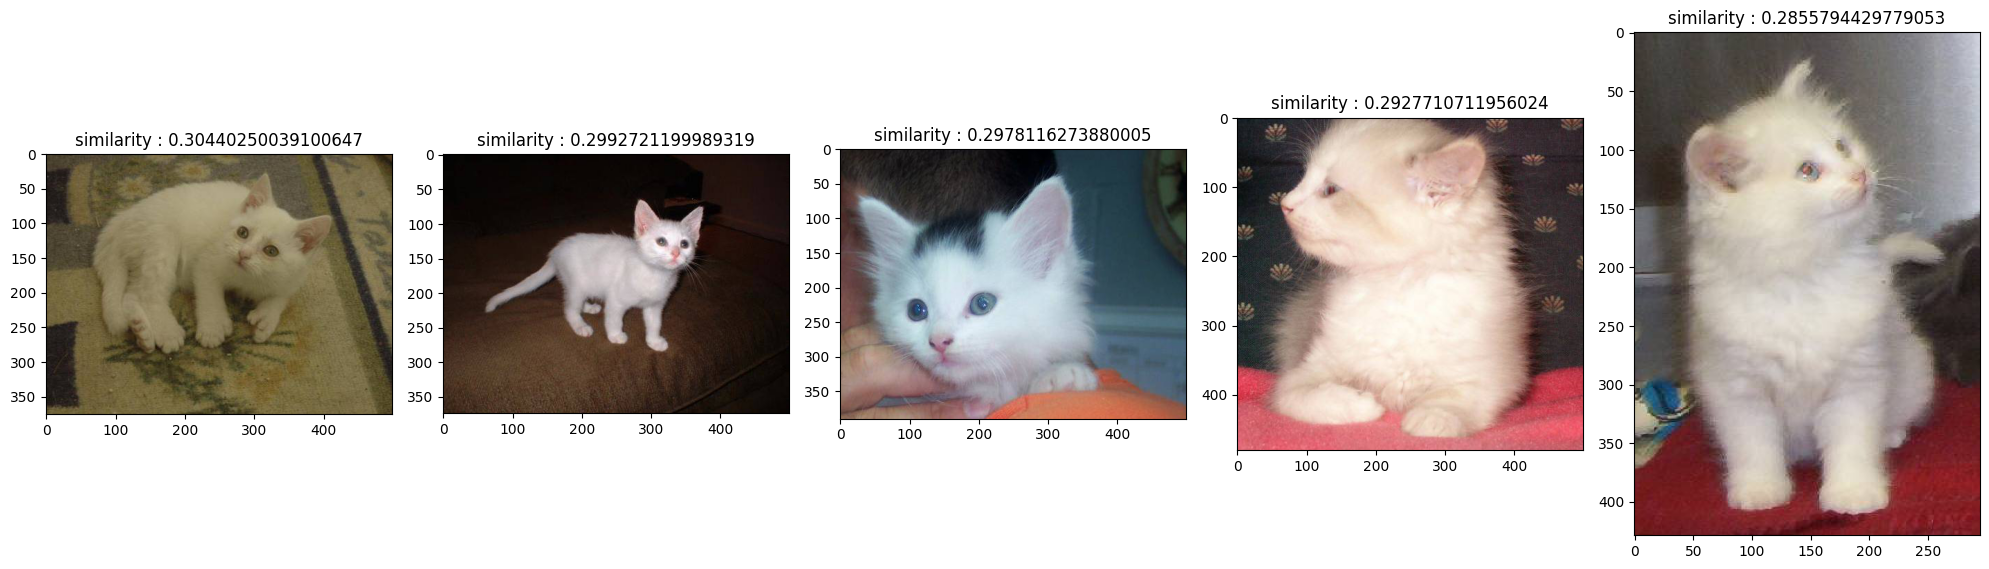

In [9]:
search_query = "little white cat"
text_query_image(model, search_query, image_embeddings, images_files, 5)

In [12]:
search_query = "cat_dog_test1/11.jpg"
image_query_text(model, search_query, image_embeddings, text_embeddings, text_files, 1)

['cat']

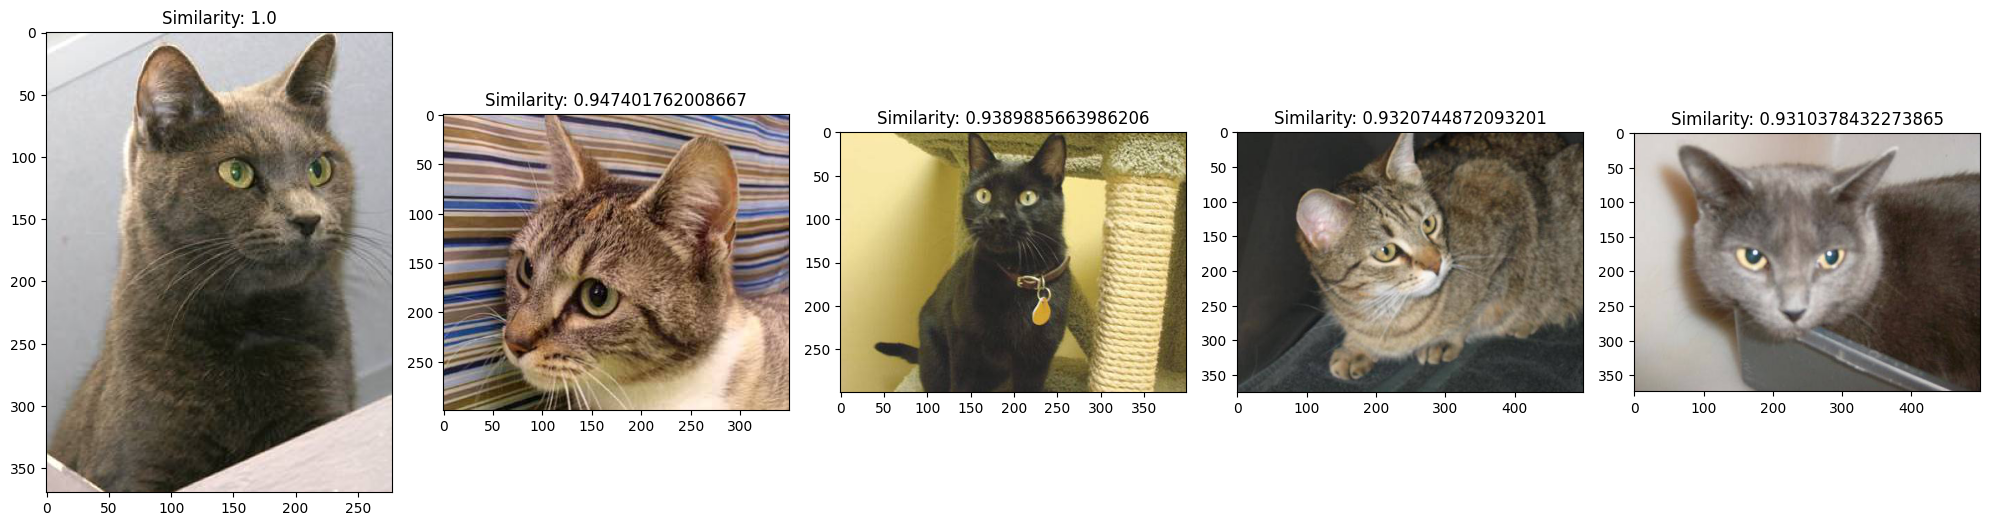

In [13]:
search_query = "cat_dog_test1/11.jpg"
image_query_image(model, search_query, image_embeddings, images_files, 5)